In [63]:
import torch

import matplotlib.pyplot as plt

from transformers import Owlv2Processor, Owlv2ForObjectDetection
from PIL import Image

In [64]:
import numpy as np
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.cpu().squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

In [65]:
processor = Owlv2Processor.from_pretrained("/home/omilab-gpu/OWLv2-For_SAP_scenes_recognition/owlvit-base-patch32_FT_sap_scenes_recognition")
model = Owlv2ForObjectDetection.from_pretrained("/home/omilab-gpu/OWLv2-For_SAP_scenes_recognition/owlvit-base-patch32_FT_sap_scenes_recognition").cuda()

In [66]:
target_image = Image.open("/home/omilab-gpu/OWLv2-For_SAP_scenes_recognition/data/Screenshot 2024-03-13 at 12.06.48.jpg")
target_sizes = torch.Tensor([target_image.size[::-1]])

# Source image
source_image = Image.open("//home/omilab-gpu/OWLv2-For_SAP_scenes_recognition/data/val/images/woman1_front_78.jpg")

In [67]:
# Define the device to use for processing.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Process input and query images using the preprocessor.
inputs = processor(images=source_image, query_images=target_image, return_tensors="pt").to(device)

# Print the input names and shapes.
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 960, 960])
pixel_values: torch.Size([1, 3, 960, 960])


In [68]:
inputs

{'query_pixel_values': tensor([[[[1.9303, 1.9303, 1.9303,  ..., 0.0690, 0.0690, 0.0690],
          [1.9303, 1.9303, 1.9303,  ..., 0.0690, 0.0690, 0.0690],
          [1.9303, 1.9303, 1.9303,  ..., 0.0690, 0.0690, 0.0690],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 0.0690, 0.0690, 0.0690],
          [1.9303, 1.9303, 1.9303,  ..., 0.0690, 0.0690, 0.0690],
          [1.9303, 1.9303, 1.9303,  ..., 0.0690, 0.0690, 0.0690]],

         [[2.0749, 2.0749, 2.0749,  ..., 0.1614, 0.1614, 0.1614],
          [2.0749, 2.0749, 2.0749,  ..., 0.1614, 0.1614, 0.1614],
          [2.0749, 2.0749, 2.0749,  ..., 0.1614, 0.1614, 0.1614],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 0.1614, 0.1614, 0.1614],
          [2.0749, 2.0749, 2.0749,  ..., 0.1614, 0.1614, 0.1614],
          [2.0749, 2.0749, 2.0749,  ..., 0.1614, 0.1614, 0.1614]],

         [[2.1459, 2.1459, 2.1459,  ..., 0.3328, 0.3328, 0.3328],
          [2.1459, 2.1459, 2.1459,  ..., 0.3328, 0.3328, 0.3328],
          [2.1459, 

In [69]:
# Perform image-guided object detection using the model.
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

# Print the shapes of the model's outputs.
for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 3600, 1])
image_embeds: shape of torch.Size([1, 60, 60, 768])
query_image_embeds: shape of torch.Size([1, 60, 60, 768])
target_pred_boxes: shape of torch.Size([1, 3600, 4])
query_pred_boxes: shape of torch.Size([1, 3600, 4])
class_embeds: shape of torch.Size([1, 3600, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 3601, 768])
pooler_output: shape of torch.Size([1, 768])


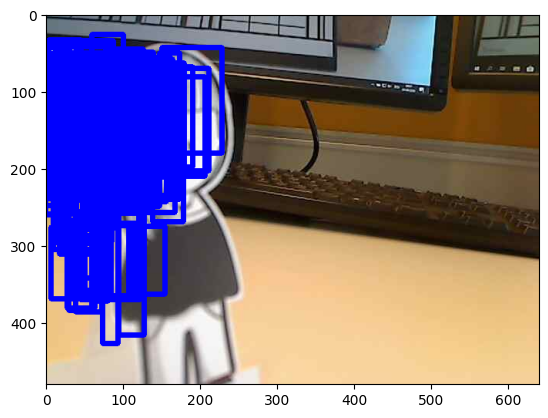

In [76]:
# Visualize the results
import numpy as np
import cv2

# Convert the image to RGB format.
img = cv2.cvtColor(np.array(source_image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

# Post-process the detection results.
results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.99, nms_threshold=0.1, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw bounding boxes on the image.
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255, 0, 0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25

# Display the image with predicted bounding boxes.
plt.imshow(img[:, :, ::-1])

In [77]:
print(results)

[{'scores': tensor([0.9915, 0.9928, 0.9940, 0.9903, 0.9897, 0.9935, 0.9911, 0.9947, 0.9921,
        0.9913, 0.9914, 0.9941, 0.9945, 0.9987, 0.9934, 0.9891, 0.9985, 0.9945,
        0.9939, 0.9901, 0.9982, 0.9965, 0.9978, 0.9938, 0.9983, 0.9966, 0.9988,
        0.9984, 0.9980, 0.9982, 0.9927, 0.9922, 0.9945, 0.9915, 0.9968, 0.9960,
        0.9997, 0.9948, 0.9961, 0.9964, 0.9959, 0.9986, 0.9956, 0.9986, 0.9905,
        0.9983, 1.0000, 0.9979, 1.0000, 0.9917, 0.9995, 0.9995, 0.9971, 0.9994,
        0.9974, 1.0000, 0.9993, 0.9997, 0.9993, 0.9992, 0.9992, 0.9951, 0.9995,
        0.9980, 0.9998, 0.9995, 0.9990, 0.9973, 0.9936, 0.9937, 0.9971, 0.9957,
        0.9976, 0.9982, 0.9955, 0.9906, 0.9998, 0.9942, 0.9911, 0.9981, 0.9935,
        0.9926, 0.9938, 0.9911, 0.9911, 0.9981, 0.9984]), 'labels': None, 'boxes': tensor([[ 14.0059,  38.0841,  85.3367, 163.7341],
        [ 17.7478,  34.1149,  87.0391, 158.6341],
        [127.5744,  56.9313, 159.0179, 183.1151],
        [135.0138,  58.9092, 164.92